#  Train a model with many observables (no external parameter dependence)

In [1]:
#  Required imports

print("Importing standard library")
import os, sys, time

print("Importing python data libraries")
import numpy as np
from   scipy      import stats, integrate, special
from   matplotlib import pyplot as plt, colors
from   iminuit    import Minuit

print("Importing third party libraries")
import dill as pickle

print("Importing custom backends")
sys.path.append("/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation")
from backends.density_model    import DensityModel, get_sum_gauss_density
from backends.plot             import histo_to_line, plot_data, plot_ratio, plot_pull, get_ratio_1D
from backends.stats            import whiten_axes, unwhiten_axes
from backends.utils            import make_sure_dir_exists_for_filename, joint_shuffle

from backends import plot as plot, density_model as density_model


Importing standard library
Importing python data libraries
Importing third party libraries
Importing custom backends


In [2]:
#  Model config

num_gaussians            = 20
max_epochs               = 300
batch_size               = 500
early_stopping_patience  = 20
early_stopping_min_delta = 1e-6
validation_split         = 0.4

gauss_width_factor = 1./4.
batch_norm         = False
dropout            = -1.

learning_rate              = 1e-3
learning_rate_evo_factor   = 0.5
learning_rate_evo_patience = 2
optimiser                  = "adam"

n_gen = int(5e4)

n_true = int(4e2)


### Define toy model

\begin{equation}
p \left( \vec x \right) ~=~ \prod_{~i~=~0}^{~j~<~{\rm dim} (x)} p \left( x_i | x_{<i} \right)
\end{equation}

In [3]:

x0_range = [100., 800.]
x1_range = x0_range
x2_range = [-np.pi, np.pi]

alpha_x0, beta_x0, gamma_x0 = 10, 1, 1
f1_x0         = np.exp(2*(alpha_x0*beta_x0+gamma_x0)) / alpha_x0 / (np.exp(2*(alpha_x0*beta_x0+gamma_x0)) - 1) 
int_const_x0  = (alpha_x0*beta_x0 + gamma_x0) * f1_x0
norm_const_x0 = 2 * int_const_x0

def base_prob (x0) :
    return 1. / (1 + np.exp(alpha_x0*(x0-beta_x0)-gamma_x0)) / (1 + np.exp(-alpha_x0*(x0+beta_x0)-gamma_x0)) / norm_const_x0
    
def base_int (x0) :
    f2 = np.exp(alpha_x0*(beta_x0+x0) + gamma_x0) + 1
    f3 = np.exp(alpha_x0*beta_x0 + gamma_x0) + np.exp(alpha_x0*x0)
    return (f1_x0 * np.log( f2 / f3 ) + int_const_x0) / norm_const_x0

def base_inv (I0) :
    L   = np.exp( (I0*norm_const_x0 - int_const_x0) / f1_x0 )
    num = L*np.exp(alpha_x0*beta_x0 + gamma_x0) - 1.
    den = np.exp(alpha_x0*beta_x0 + gamma_x0) - L
    return np.log(num / den) / alpha_x0


def p_x0 (c, x0) :
    c  = np.fabs(c[0])
    x0 = (x0 - x0_range[0]) / (x0_range[1] - x0_range[0])
    A  = 2.
    N  = A*(2-c) / (1. - np.exp(-A*(2-c)))
    return N * np.exp(-A*(2-c)*x0) / (x0_range[1] - x0_range[0])
    
def int_x0 (c, x0) :
    c  = np.fabs(c[0])
    x0   = (x0 - x0_range[0]) / (x0_range[1] - x0_range[0])
    A    = 2.
    N    = A*(2-c) / (1. - np.exp(-A*(2-c)))
    zero = - N / (A*(2-c))
    return - (N * np.exp(-A*(2-c)*x0) / (A*(2-c))) - zero

def inv_int_x0 (c, I0) :
    c  = np.fabs(c[0])
    A  = 2.
    N  = A*(2-c) / (1. - np.exp(-A*(2-c)))
    x0 = - np.log(1 - A*(2-c)/N*I0) / A / (2-c)
    return x0_range[0] + x0*(x0_range[1] - x0_range[0])


def p_x1 (c, x0, x1) :
    c     = np.fabs(c[0])
    x0    = (x0 - x0_range[0]) / (x0_range[1] - x0_range[0])
    x1    = (x1 - x1_range[0]) / (x1_range[1] - x1_range[0])
    sigma = 0.05
    N     = - np.sqrt(0.5*np.pi) * sigma * (special.erf((x0 - 1.) / np.sqrt(2) / sigma) - special.erf((x0 - 0.) / np.sqrt(2) / sigma))
    return np.exp(-(x1-x0)*(x1-x0)/2./sigma/sigma) / N / (x1_range[1] - x1_range[0])
    
def int_x1 (c, x0, x1) :
    c     = np.fabs(c[0])
    x0    = (x0 - x0_range[0]) / (x0_range[1] - x0_range[0])
    x1    = (x1 - x1_range[0]) / (x1_range[1] - x1_range[0])
    sigma = 0.05
    N     = special.erf((x0 - 1.) / np.sqrt(2) / sigma) - special.erf((x0 - 0.) / np.sqrt(2) / sigma)
    intgl = special.erf((x0 - x1) / np.sqrt(2) / sigma) - special.erf((x0 - 0.) / np.sqrt(2) / sigma)
    return intgl / N

def inv_int_x1 (c, x0, I1) :
    c     = np.fabs(c[0])
    r     = (x1_range[1] - x1_range[0])
    x0    = (x0 - x0_range[0]) / (x0_range[1] - x0_range[0])
    sigma = 0.05
    N     = special.erf((x0 - 1.) / np.sqrt(2) / sigma) - special.erf((x0 - 0.) / np.sqrt(2) / sigma)
    zero  = special.erf((x0 - 0.) / np.sqrt(2) / sigma)
    x1    = x0 - sigma * np.sqrt(2) * special.erfinv(N*I1 + zero)
    return x1_range[0] + x1*(x1_range[1] - x1_range[0])


def p_x2 (c, x2) :
    c0, c1 = c[0], c[1]
    A, B, C, D, E = 1., 4./np.pi/np.pi, -5./np.pi/np.pi/np.pi/np.pi, 0.4*c0, 0.5*c1
    y = (A + B*x2*x2 + C*x2*x2*x2*x2) * (1 + D*np.sin(x2) + E*np.cos(x2))
    I = int_f2(c, np.pi) - int_f2(c, -np.pi)
    return y / I
        
def int_f2 (c, x) :
    c0, c1 = c[0], c[1]
    A, B, C, D, E = 1., 4./np.pi/np.pi, -5./np.pi/np.pi/np.pi/np.pi, 0.4*c0, 0.5*c1
    sin_factor =  A*E + 2*B*D*x + B*E*(x*x-2) + 4*C*D*x*(x*x-6) + C*E*(x*x*x*x - 12*x*x + 24)
    cos_factor = -A*D + 2*B*E*x - B*D*(x*x-2) + 4*C*E*x*(x*x-6) - C*D*(x*x*x*x - 12*x*x + 24)
    I = sin_factor*np.sin(x) + cos_factor*np.cos(x) + A*x + B*x*x*x/3. + C*x*x*x*x*x/5.
    return I 
    
def int_x2 (c, x2) :
    I_lo = int_f2(c, -np.pi)
    I_hi = int_f2(c, np.pi )
    I_x  = int_f2(c, x2    )
    return (I_x - I_lo) / (I_hi - I_lo)

def inv_int_x2 (c, I2, n_pt=1001) :
    x = np.linspace(-np.pi, np.pi, n_pt)
    y = int_x2(c, x)
    return np.interp(I2, y, x)


def p_x3 (c, x0, x1, x2, x3) :
    c0, c1 = c[0], c[1]
    x0 = 2*(x0 - x0_range[0]) / (x0_range[1] - x0_range[0]) - 1.
    x1 = 2*(x1 - x1_range[0]) / (x1_range[1] - x1_range[0]) - 1.
    x2 = (x2 + np.pi) / np.pi - 1.
    x3 = x3 + .6*(np.sqrt(4. + np.fabs(c0)) + np.fabs(c1))*(x1 + x2)
    return base_prob(x3)
    
def int_x3 (c, x0, x1, x2, x3) :
    c0, c1 = c[0], c[1]
    x0 = 2*(x0 - x0_range[0]) / (x0_range[1] - x0_range[0]) - 1.
    x1 = 2*(x1 - x1_range[0]) / (x1_range[1] - x1_range[0]) - 1.
    x2 = (x2 + np.pi) / np.pi - 1.
    x3 = x3 + .6*(np.sqrt(4. + np.fabs(c0)) + np.fabs(c1))*(x1 + x2)
    return base_int(x3)

def inv_int_x3 (c, x0, x1, x2, I3) :
    c0, c1 = c[0], c[1]
    x0 = 2*(x0 - x0_range[0]) / (x0_range[1] - x0_range[0]) - 1.
    x1 = 2*(x1 - x1_range[0]) / (x1_range[1] - x1_range[0]) - 1.
    x2 = (x2 + np.pi) / np.pi - 1.
    u3 = base_inv(I3)
    return base_inv(I3) - .6*(np.sqrt(4. + np.fabs(c0)) + np.fabs(c1))*(x1 + x2)


def evaluate (c, x) :
    if type(x) != np.ndarray : x = np.array(x)
    if len(x.shape) == 1 : x = x.reshape(1, len(x))
    logL = np.log(p_x0(c, x[:,0])) + np.log(p_x1(c, x[:,0], x[:,1])) + np.log(p_x2(c, x[:,2])) + np.log(p_x3(c, x[:,0], x[:,1], x[:,2], x[:,3]))
    return np.sum(logL)

def evaluate_partial (c, x) :
    if type(x) != np.ndarray : x = np.array(x)
    if len(x.shape) == 1 : x = x.reshape(1, len(x))
    logL = np.log(p_x0(c, x[:,0])) + np.log(p_x1(c, x[:,0], x[:,1])) + np.log(p_x2(c, x[:,2]))
    return np.sum(logL)

def generate (c, n_pts) :
    u0 = np.random.uniform(low=0, high=1, size=int(n_pts))
    x0 = inv_int_x0(c, u0)
    u1 = np.random.uniform(low=0, high=1, size=int(n_pts))
    x1 = inv_int_x1(c, x0, u1)
    u2 = np.random.uniform(low=0, high=1, size=int(n_pts))
    x2 = inv_int_x2(c, u2)
    u3 = np.random.uniform(low=0, high=1, size=int(n_pts))
    x3 = inv_int_x3(c, x0, x1, x2, u3)
    return np.array([x0, x1, x2, x3]).transpose()


In [4]:

c0_gen, c1_gen = np.linspace(-1.5, 1.5, 7), np.linspace(-1.5, 1.5, 7)
c_gen = []
for c0 in c0_gen :
    for c1 in c1_gen :
        c_gen.append((c0, c1))
num_observables = -1
datapoints_dict, weights_dict = {}, {}
for c in c_gen :
    datapoints_dict [c] = generate(c, n_gen)
    weights_dict    [c] = np.ones(shape=(n_gen,))
    num_observables = datapoints_dict[c].shape[1]
    
x3_range = [np.min([datapoints_dict[c][:,3] for c in c_gen]), np.max([datapoints_dict[c][:,3] for c in c_gen])]

print(f"x3_range is {x3_range}")


x3_range is [-5.76747789864498, 5.801976651937799]


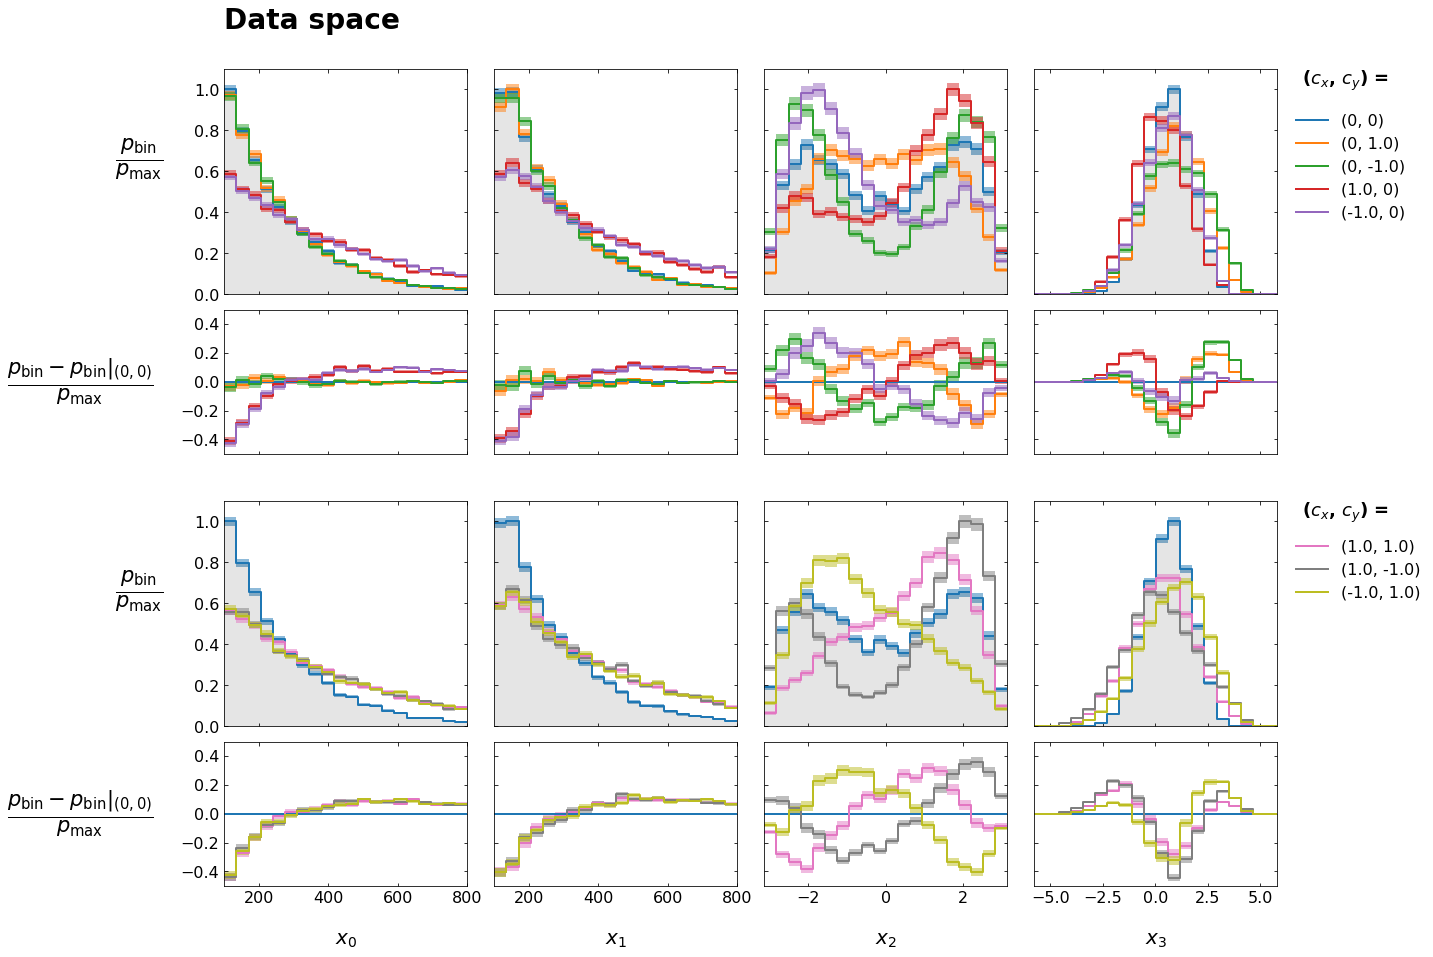

In [5]:
#  Plot 1D

prop_cycle = plt.rcParams['axes.prop_cycle']
colours = prop_cycle.by_key()['color']

def plot (c_plot, white=False, title="", savefig="") :
    fig = plt.figure(figsize=(15, 12))
    dp = {}
    for row_idx in range(2) :
        c_offset = 5 if row_idx == 1 else 0
        axes = []
        for obs_idx in range(num_observables) :
            ax_top    = fig.add_axes([obs_idx/num_observables, (1-row_idx)*.5 + .45*0.41, 0.9/num_observables, .45*.58])
            obs_range = [-5, 5] if white else {0:x0_range, 1:x1_range, 2:x2_range, 3:x3_range}[obs_idx]
            hbins     = np.linspace(obs_range[0], obs_range[1], 21)
            ax_top.set_xlim([obs_range[0], obs_range[1]])
            ax_top.tick_params(axis="both", direction="in", right=True, top=True, labelsize=16, pad=5)
            ax_top.set_xticklabels([])
            if obs_idx > 0 : ax_top.set_yticklabels([])
            ypadmax, vals = 0., {}
            for c_idx, c in enumerate(c_plot[row_idx]) :
                if c not in dp : dp[c] = generate(c, int(1e4))
                ds = white_data[c][:,obs_idx] if white else dp[c][:,obs_idx]
                vals[c], _ = np.histogram(ds, bins=hbins)
                ypadmax    = np.max([ypadmax, np.max(vals[c])])
            for c_idx, c in enumerate(c_plot[row_idx]) :
                colour = colours[c_offset+c_idx] if c_idx > 0 else colours[0]
                x, y, ey = histo_to_line(hbins, vals[c], np.sqrt(vals[c]))
                y, ey = y/ypadmax, ey/ypadmax
                ax_top.plot        (x, y, lw=2, label=None if row_idx>0 and c[0]==0 and c[1]==0 else f"{c}", c=colour)
                ax_top.fill_between(x, y-ey, y+ey, alpha=0.5, fc=colour)
                if (c[0] == 0) and (c[1] == 0) : ax_top.fill_between(x, 0*y, y, alpha=0.1, fc="black")
            ax_top.set_ylim(0, 1.1)

            ax_ratio = fig.add_axes([obs_idx/num_observables, (1-row_idx)*.5 + .45*0, 0.9/num_observables, .45*.37])
            ax_ratio.set_xlim([obs_range[0], obs_range[1]])
            ax_ratio.tick_params(axis="both", direction="in", right=True, top=True, labelsize=16, pad=5)
            if obs_idx > 0 : ax_ratio.set_yticklabels([])
            ax_ratio.set_ylim(-0.5, 0.5)
            ax_ratio.set_yticks([-0.4, -0.2, 0., 0.2, 0.4])
            if row_idx == 0 :
                ax_ratio.set_xticklabels([])
            else :
                ax_ratio.set_xlabel(f"${'u' if white else 'x'}_{obs_idx}$", fontsize=20, labelpad=25, ha="center")

            for c_idx, c in enumerate(c_plot[row_idx]) :
                colour = colours[c_offset+c_idx] if c_idx > 0 else colours[0]
                x, y, ey       = histo_to_line(hbins, vals[c], np.sqrt(vals[c]))
                _, y_SM, ey_SM = histo_to_line(hbins, vals[(0,0)], np.sqrt(vals[(0,0)]))
                y, ey, y_SM, ey_SM = y/ypadmax, ey/ypadmax, y_SM/ypadmax, ey_SM/ypadmax
                ey_comb = np.sqrt(ey*ey + ey_SM*ey_SM)
                if (c[0] == 0) and (c[1] == 0) : ey_comb = 0.*ey_comb
                ax_ratio.plot        (x, y - y_SM, lw=2, c=colour)
                ax_ratio.fill_between(x, y - y_SM - ey_comb, y - y_SM + ey_comb, alpha=0.5, fc=colour)

            axes.append([ax_top, ax_ratio])

        axes[-1][0].text(1.1, 1, r"($c_x$, $c_y$) =", ha="left", va="top", fontsize=18, weight="bold", transform=axes[-1][0].transAxes)
        axes[-1][0].legend(loc=(1.05, .30 if row_idx == 0 else .53), frameon=False, fontsize=16)
        axes[0 ][0].set_ylabel(r"$\frac{p_{\rm bin}}{p_{\rm max}}$", fontsize=30, rotation=0, labelpad=55)
        axes[0 ][1].set_ylabel(r"$\frac{p_{\rm bin} - p_{\rm bin}|_{(0,0)}}{p_{\rm max}}$", fontsize=30, rotation=0, labelpad=100, va="center")
        if (len(title) > 0) and (row_idx == 0) : axes[0][0].text(0, 1.15, title, ha="left", va="bottom", fontsize=28, weight="bold", transform=axes[0][0].transAxes)

    if len(savefig) > 0 : plt.savefig(savefig, bbox_inches="tight")
    plt.show()

plot([[(0, 0), (0, 1.), (0, -1.), (1., 0), (-1., 0)], [(0, 0), (1., 1.), (1., -1.), (-1., 1.)]],
     title="Data space", savefig="figures/paper2D_toy_model/data_distributions.pdf")


In [6]:

whitening_func_form = "step"
whitening_alpha, whitening_beta, whitening_gamma = 4, 3, 1

axis_configs = [[x0_range[0], x0_range[1], 200, 0.5, 0.],
                [x1_range[0], x1_range[1], 200, 0.5, 0.],
                [x2_range[0], x2_range[1], 200, 0.5, 0.],
                [x3_range[0], x3_range[1], 200, 0.5, 0.]]
    
print("Getting whitening funcs")
_, whitening_funcs = whiten_axes(datapoints_dict[(0.,0.)], [float for i in range(num_observables)], axis_configs=axis_configs, func_form=whitening_func_form, alpha=whitening_alpha, beta=whitening_beta, gamma=whitening_gamma)

white_data = {}
for c in c_gen :
    print(f"Whitening c = {c}")
    white_data[c], _ = whiten_axes(datapoints_dict[c], [float for i in range(num_observables)], axis_configs=axis_configs, whitening_funcs=whitening_funcs)
    

Getting whitening funcs
Whitening c = (-1.5, -1.5)
Whitening c = (-1.5, -1.0)
Whitening c = (-1.5, -0.5)
Whitening c = (-1.5, 0.0)
Whitening c = (-1.5, 0.5)
Whitening c = (-1.5, 1.0)
Whitening c = (-1.5, 1.5)
Whitening c = (-1.0, -1.5)
Whitening c = (-1.0, -1.0)
Whitening c = (-1.0, -0.5)
Whitening c = (-1.0, 0.0)
Whitening c = (-1.0, 0.5)
Whitening c = (-1.0, 1.0)
Whitening c = (-1.0, 1.5)
Whitening c = (-0.5, -1.5)
Whitening c = (-0.5, -1.0)
Whitening c = (-0.5, -0.5)
Whitening c = (-0.5, 0.0)
Whitening c = (-0.5, 0.5)
Whitening c = (-0.5, 1.0)
Whitening c = (-0.5, 1.5)
Whitening c = (0.0, -1.5)
Whitening c = (0.0, -1.0)
Whitening c = (0.0, -0.5)
Whitening c = (0.0, 0.0)
Whitening c = (0.0, 0.5)
Whitening c = (0.0, 1.0)
Whitening c = (0.0, 1.5)
Whitening c = (0.5, -1.5)
Whitening c = (0.5, -1.0)
Whitening c = (0.5, -0.5)
Whitening c = (0.5, 0.0)
Whitening c = (0.5, 0.5)
Whitening c = (0.5, 1.0)
Whitening c = (0.5, 1.5)
Whitening c = (1.0, -1.5)
Whitening c = (1.0, -1.0)
Whitening c =

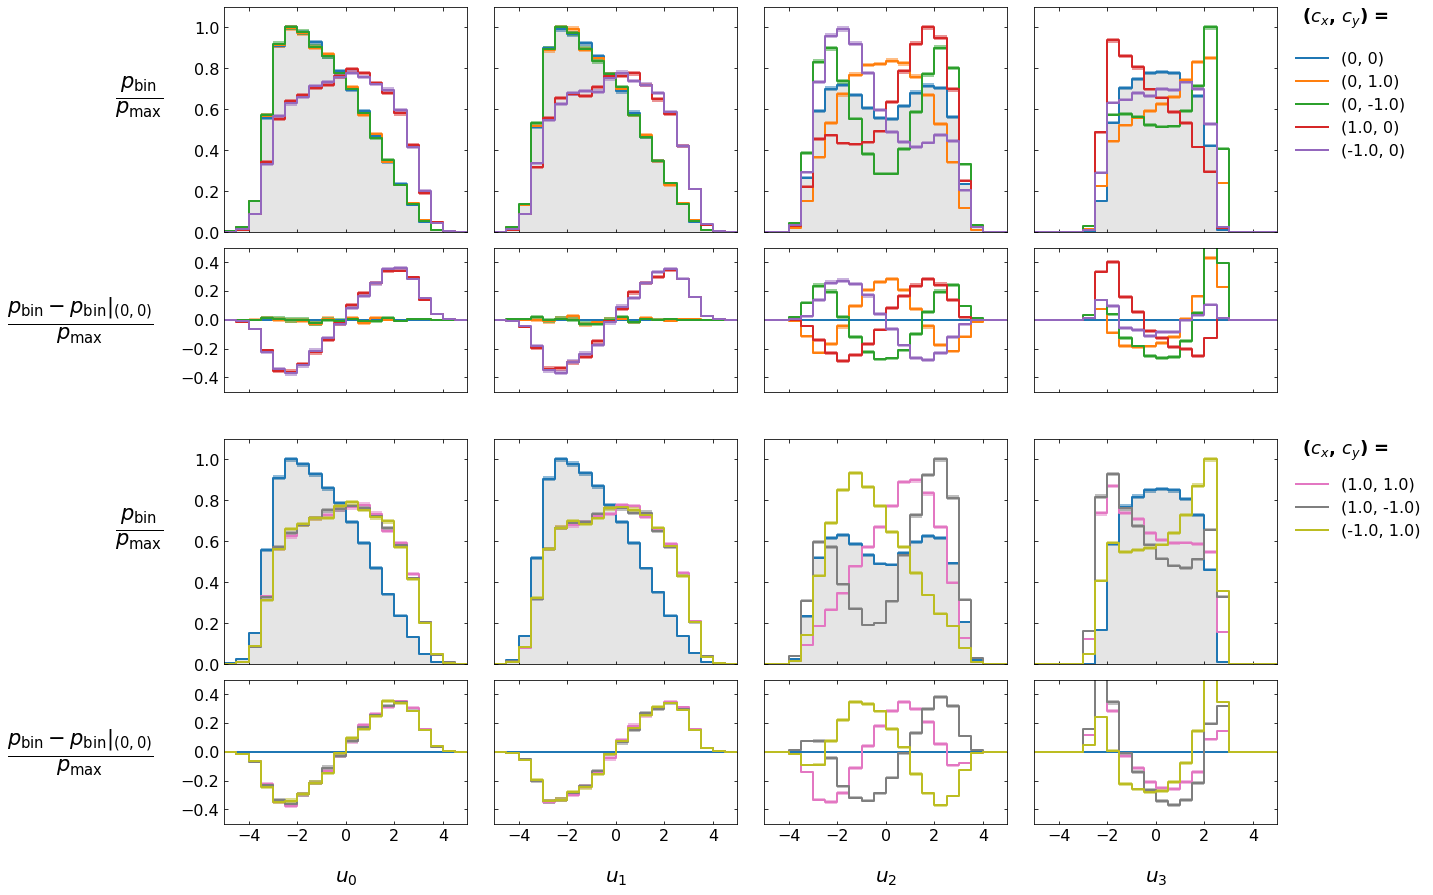

In [7]:
#  Plot 1D

plot([[(0, 0), (0, 1.), (0, -1.), (1., 0), (-1., 0)], [(0, 0), (1., 1.), (1., -1.), (-1., 1.)]], white=True)

In [8]:
#=====================================
#===   BUILD&FIT MARGINAL MODELS   ===
#=====================================

marginal_density_models = []

for obs_idx in range(num_observables) :
    min_dp, max_dp     = np.min([white_data[c][:,obs_idx] for c in c_gen]), np.max([white_data[c][:,obs_idx] for c in c_gen])
    range_dp_per_gauss = (max_dp - min_dp) / num_gaussians
    obs_lims = [[min_dp + 0.5*range_dp_per_gauss, max_dp - 0.5*range_dp_per_gauss]]
    
    marginal_white_data = {c:white_data[c][:,obs_idx].reshape((-1,1)) for c in c_gen}
    
    marginal_density_model = DensityModel(name               = f"Marginal_density_model_obs{obs_idx}", 
                                 num_gaussians      = num_gaussians        , 
                                 num_conditions     = 2                    , 
                                 num_observables    = 1                    ,
                                 observables_limits = obs_lims             ,
                                 verbose            = True                 , 
                                 gauss_width_factor = gauss_width_factor   ,
                                 gauss_mean_scale   = 1./100.              ,
                                 gauss_frac_scale   = 1./100.              ,
                                 gauss_sigma_scale  = 1./100.              ,
                                 optimiser          = optimiser            ,
                                 learning_rate      = learning_rate        ,
                                 A1                 = 50                   ,
                                 A2                 = 0                    ,
                                 B1                 = 50                   ,
                                 B2                 = 20                   ,
                                 C_float            = 2                    ,
                                 D2                 = 2                    )
    
    marginal_density_model.ensure_valid_over_dataset (marginal_white_data, weights_dict)
    
    marginal_density_model.fit(marginal_white_data                            ,
                      weights_dict                                            ,
                      max_epochs_per_observable  = 10                         ,
                      early_stopping_patience    = early_stopping_patience    ,
                      early_stopping_min_delta   = early_stopping_min_delta   ,
                      validation_split           = validation_split           ,
                      batch_size_per_observable  = batch_size                 ,
                      learning_rate_evo_factor   = learning_rate_evo_factor   ,
                      learning_rate_evo_patience = learning_rate_evo_patience )
    
    marginal_density_models.append(marginal_density_model)


No observable types argument provided - assuming all are floats
INFO       DensityModel.construct      Set model name              : Marginal_density_model_obs0
INFO       DensityModel.construct      Set model num_gaussians     : 20
INFO       DensityModel.construct      Set model num_conditions    : 2
INFO       DensityModel.construct      Set model num_observables   : 1
INFO       DensityModel.construct      Set observable types        : [<class 'float'>]
INFO       DensityModel.construct      Set bias_initializer        : zeros
INFO       DensityModel.construct      Set learning_rate           : 0.001
INFO       DensityModel.construct      Set learning_rate_evo_factor: 1.0
INFO       DensityModel.construct      Set optimiser               : adam
INFO       DensityModel.construct      Set activation              : leakyrelu
INFO       DensityModel.construct      Set min_gauss_amplitude_frac: 0.0
INFO       DensityModel.construct      Set gauss_width_factor      : 0.25
INFO       Dens

W0504 13:39:20.995489 4670268864 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_v1.py:2070: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Evaluating losses  (attempt 1 / 100)
-  observable logL are [-6010893.8345927], combined is -6010893.8345927
-  eval completed in 51s
INFO       DensityModel.fit            Queued the following observable indices to train: 0
INFO       DensityModel.fit            Parsing training data
INFO       DensityModel.fit            Training observable index 0
INFO       DensityModel.fit              -  Training setting: epochs = 10
INFO       DensityModel.fit              -  Training setting: batch_size = 500
INFO       DensityModel.fit              -  Training setting: validation_split = 0.4
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 20
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 1e-06


W0504 13:40:23.696878 4670268864 module_wrapper.py:138] From /Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/density_model.py:877: The name tf.keras.backend.get_session is deprecated. Please use tf.compat.v1.keras.backend.get_session instead.



Train on 1470000 samples, validate on 980000 samples
Epoch 1/10
1470000/1470000 [==============================] - 17s 11us/sample - loss: 1.9478 - val_loss: 1.9339
Epoch 2/10
1470000/1470000 [==============================] - 19s 13us/sample - loss: 1.9343 - val_loss: 1.9346
Epoch 3/10
1470000/1470000 [==============================] - 19s 13us/sample - loss: 1.9341 - val_loss: 1.9337
Epoch 4/10
1470000/1470000 [==============================] - 20s 13us/sample - loss: 1.9339 - val_loss: 1.9337
Epoch 5/10
1470000/1470000 [==============================] - 21s 14us/sample - loss: 1.9339 - val_loss: 1.9334
Epoch 6/10
1470000/1470000 [==============================] - 20s 14us/sample - loss: 1.9338 - val_loss: 1.9337
Epoch 7/10
1470000/1470000 [==============================] - 20s 14us/sample - loss: 1.9337 - val_loss: 1.9337
Epoch 8/10
1470000/1470000 [==============================] - 19s 13us/sample - loss: 1.9333 - val_loss: 1.9334
Epoch 9/10
1470000/1470000 [=======================

Evaluating losses  (attempt 1 / 100)
-  observable logL are [-5981746.93999124], combined is -5981746.939991236
-  eval completed in 52s
INFO       DensityModel.fit            Queued the following observable indices to train: 0
INFO       DensityModel.fit            Parsing training data
INFO       DensityModel.fit            Training observable index 0
INFO       DensityModel.fit              -  Training setting: epochs = 10
INFO       DensityModel.fit              -  Training setting: batch_size = 500
INFO       DensityModel.fit              -  Training setting: validation_split = 0.4
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 20
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 1e-06
Train on 1470000 samples, validate on 980000 samples
Epoch 1/10
1470000/1470000 [==============================] - 16s 11us/sample - loss: 1.9444 - val_loss: 1.9305
Epoch 2/10
1470000/1470000 [===========================

Evaluating losses  (attempt 1 / 100)
-  observable logL are [-5943008.46724832], combined is -5943008.467248321
-  eval completed in 58s
INFO       DensityModel.fit            Queued the following observable indices to train: 0
INFO       DensityModel.fit            Parsing training data
INFO       DensityModel.fit            Training observable index 0
INFO       DensityModel.fit              -  Training setting: epochs = 10
INFO       DensityModel.fit              -  Training setting: batch_size = 500
INFO       DensityModel.fit              -  Training setting: validation_split = 0.4
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 20
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 1e-06
Train on 1470000 samples, validate on 980000 samples
Epoch 1/10
1470000/1470000 [==============================] - 19s 13us/sample - loss: 1.8349 - val_loss: 1.8227
Epoch 2/10
1470000/1470000 [===========================

Evaluating losses  (attempt 1 / 100)
-  observable logL are [-6015164.80182147], combined is -6015164.80182147
-  eval completed in 61s
INFO       DensityModel.fit            Queued the following observable indices to train: 0
INFO       DensityModel.fit            Parsing training data
INFO       DensityModel.fit            Training observable index 0
INFO       DensityModel.fit              -  Training setting: epochs = 10
INFO       DensityModel.fit              -  Training setting: batch_size = 500
INFO       DensityModel.fit              -  Training setting: validation_split = 0.4
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 20
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 1e-06
Train on 1470000 samples, validate on 980000 samples
Epoch 1/10
1470000/1470000 [==============================] - 18s 12us/sample - loss: 1.6743 - val_loss: 1.6559
Epoch 2/10
1470000/1470000 [============================

Generating 10000 fake datapoints for [c0, c1] = [0, 0]
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints,

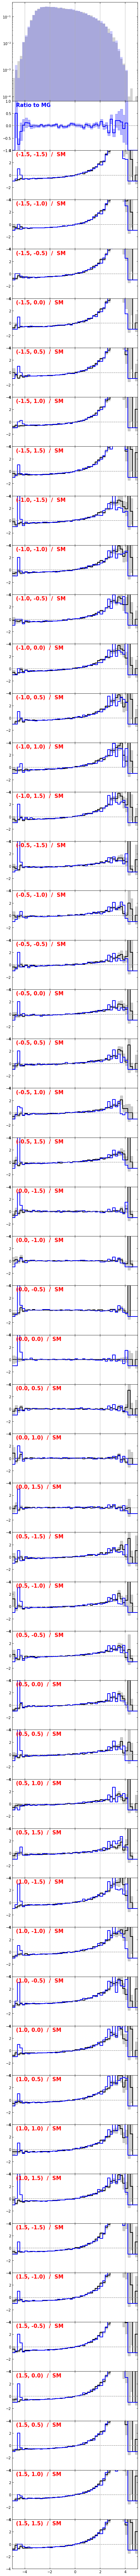

Generating 10000 fake datapoints for [c0, c1] = [0, 0]
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints,

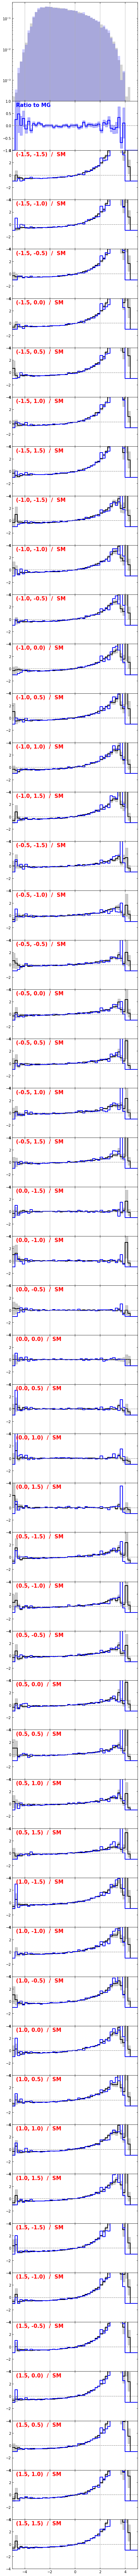

Generating 10000 fake datapoints for [c0, c1] = [0, 0]
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints,

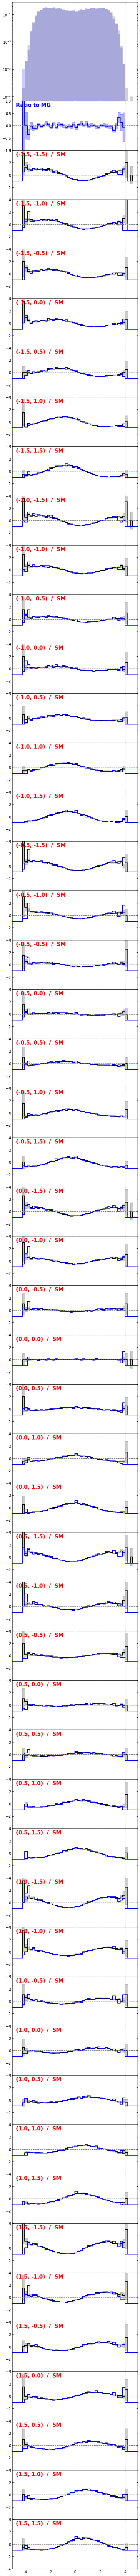

Generating 10000 fake datapoints for [c0, c1] = [0, 0]
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 10000 datapoints,

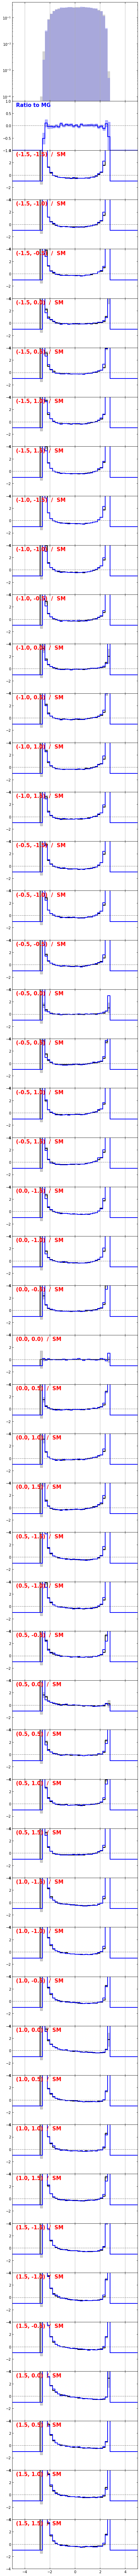

In [9]:
num_wilson_pairs = len(c_gen)

bins = np.linspace(-5, 5, 51)
def get_histo (ds) :
    bin_entries , _  = np.histogram(ds, bins=bins)
    frac_errors      = np.array([1./x if x > 0 else 0. for x in np.sqrt(bin_entries)])
    return bin_entries / np.sum(bin_entries), frac_errors

def safe_divide (num, den, rogue=0.) :
    assert len(num) == len(den), f"len(num) ({len(num)}) != len(den) ({len(den)})"
    return np.array([x/y if y>0 else np.sign(x)*rogue for x,y in zip(num, den)])

for obs_idx in range(num_observables) :
    
    n_sample = 10000

    print(f"Generating {n_sample} fake datapoints for [c0, c1] = [0, 0]")
    start = time.time()
    marginal_density_model = marginal_density_models[obs_idx]
    fake_white_datapoints_SM = marginal_density_model.sample(n_sample, [0, 0])
    end = time.time()

    fake_white_datapoints = {}
    for c in c_gen :
        start = time.time()
        fake_white_datapoints[c] = marginal_density_model.sample(n_sample, c)
        end = time.time()
    
    fig = plt.figure(figsize=(5, 2*(2+num_wilson_pairs)))

    pad_height = 1. / (3+num_wilson_pairs)
    lower      = 1. - 2*pad_height
    ax = fig.add_axes([0, lower, 1, 2*pad_height])

    ds                                   = white_data[(0,0)][:,obs_idx]
    bin_entries, frac_errors             = get_histo(ds)
    bin_entries_model, frac_errors_model = get_histo(fake_white_datapoints_SM)
    ax.hist(ds, density=True, color="darkgrey", alpha=0.5, bins=bins)
    ax.hist(fake_white_datapoints_SM, density=True, color="blue", alpha=0.2, bins=bins)

    ax.set_yscale("log")
    ax.grid(which="both", axis="x")
    ax.tick_params(which='both', axis="both", direction="in", right=True, top=True)
    ax.set_xlim([-5, 5])

    lower = lower - pad_height
    ax    = fig.add_axes([0, lower, 1, pad_height]) 
    ratio_to_MG       = safe_divide(bin_entries_model, bin_entries)
    ratio_to_MG_error = ratio_to_MG*np.sqrt(frac_errors*frac_errors + frac_errors_model*frac_errors_model)      
    rat_x, rat_y, rat_ey = [], [], []
    for idx, b in enumerate(bins) :
        rat_x.append(b)
        if (idx==0) or (idx==len(bins)-1) : continue
        rat_x.append(b)
    for y, ey in zip(ratio_to_MG - 1, ratio_to_MG_error) :
        rat_y  .append(y  )
        rat_y  .append(y  )
        rat_ey .append(ey )
        rat_ey .append(ey )
    rat_x, rat_y, rat_ey = np.array(rat_x), np.array(rat_y), np.array(rat_ey)

    ax.plot(rat_x, rat_y, lw=2, color="b")
    ax.fill_between(rat_x, rat_y-rat_ey, rat_y+rat_ey, color="b", alpha=0.3)
    ax.axhline(0, ls="--", lw=1, c="grey")
    ax.text(0.03, 0.97, "Ratio to MG", ha="left", va="top", transform=ax.transAxes, fontsize=15, color="b", weight="bold")
    ax.grid(which="both", axis="x")
    ax.tick_params(which='both', axis="both", direction="in", right=True, top=True)
    ax.set_xlim([-5, 5])
    ax.set_ylim([-1, 1])

    for wilson_pair in c_gen :
        lower = lower - pad_height
        ax = fig.add_axes([0, lower, 1, pad_height])

        ds = white_data[wilson_pair][:,obs_idx]
        this_bin_entries, this_frac_errors = get_histo(ds)
        ratio_to_SM       = safe_divide(this_bin_entries, bin_entries)
        ratio_to_SM_error = ratio_to_SM*np.sqrt(frac_errors*frac_errors + this_frac_errors*this_frac_errors)

        this_bin_entries_model, this_frac_errors_model = get_histo(fake_white_datapoints[wilson_pair])
        ratio_to_SM_model       = safe_divide(this_bin_entries_model, bin_entries_model)
        ratio_to_SM_error_model = ratio_to_SM_model*np.sqrt(frac_errors_model*frac_errors_model + this_frac_errors_model*this_frac_errors_model)

        rat_x, rat_y, rat_ey, rat_ym, rat_eym = [], [], [], [], []
        for idx, b in enumerate(bins) :
            rat_x.append(b)
            if (idx==0) or (idx==len(bins)-1) : continue
            rat_x.append(b)
        for y, ey, ym, eym in zip(ratio_to_SM - 1, ratio_to_SM_error, ratio_to_SM_model - 1, ratio_to_SM_error_model) :
            rat_y  .append(y  )
            rat_y  .append(y  )
            rat_ey .append(ey )
            rat_ey .append(ey )
            rat_ym .append(ym )
            rat_ym .append(ym )
            rat_eym.append(eym)
            rat_eym.append(eym)
        rat_x, rat_y, rat_ey, rat_ym, rat_eym = np.array(rat_x), np.array(rat_y), np.array(rat_ey), np.array(rat_ym), np.array(rat_eym)

        ax.plot(rat_x, rat_y, lw=2, color="k")
        ax.fill_between(rat_x, rat_y-rat_ey, rat_y+rat_ey, color="k", alpha=0.2)
        ax.plot(rat_x, rat_ym, lw=2, color="b")
        ax.axhline(0, ls="--", lw=1, c="grey")
        ax.text(0.03, 0.97, f"{wilson_pair}  /  SM", ha="left", va="top", transform=ax.transAxes, fontsize=15, color="r", weight="bold")
        ax.grid(which="both", axis="x")
        ax.tick_params(which='both', axis="both", direction="in", right=True, top=True)
        ax.set_xlim([-5, 5])
        ax.set_ylim([-4, 4])

    plt.show()


In [10]:
#===========================
#===   BUILD&FIT MODEL   ===
#===========================

#
#   Figure out the limits of the observables
#
obs_lims = []
for obs_idx in range(num_observables) :     
    min_dp, max_dp     = np.min([white_data[c][:,obs_idx] for c in c_gen]), np.max([white_data[c][:,obs_idx] for c in c_gen])
    range_dp_per_gauss = (max_dp - min_dp) / num_gaussians
    obs_lims.append([min_dp + 0.5*range_dp_per_gauss, max_dp - 0.5*range_dp_per_gauss]) 
    
global_density_model = DensityModel(name        = "Toy_density_model"  , 
                             num_gaussians      = num_gaussians        , 
                             num_conditions     = 2                    , 
                             num_observables    = num_observables      ,
                             observables_limits = obs_lims             ,
                             verbose            = True                 , 
                             gauss_width_factor = gauss_width_factor   ,
                             gauss_mean_scale   = 1./100.              ,
                             gauss_frac_scale   = 1./100.              ,
                             gauss_sigma_scale  = 1./100.              ,
                             optimiser          = optimiser            ,
                             learning_rate      = learning_rate        ,
                             A1                 = 50                  ,
                             A2                 = 0                    ,
                             B1                 = 50                  ,
                             B2                 = 20                   ,
                             C_float            = 2                    ,
                             D2                 = 3                    ,
                             batch_norm         = batch_norm           ,
                             dropout            = dropout              )
#
#   Make sure initial state has no NaN/Inf loss
#
global_density_model.ensure_valid_over_dataset (white_data, weights_dict)


No observable types argument provided - assuming all are floats
INFO       DensityModel.construct      Set model name              : Toy_density_model
INFO       DensityModel.construct      Set model num_gaussians     : 20
INFO       DensityModel.construct      Set model num_conditions    : 2
INFO       DensityModel.construct      Set model num_observables   : 4
INFO       DensityModel.construct      Set observable types        : [<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]
INFO       DensityModel.construct      Set bias_initializer        : zeros
INFO       DensityModel.construct      Set learning_rate           : 0.001
INFO       DensityModel.construct      Set learning_rate_evo_factor: 1.0
INFO       DensityModel.construct      Set optimiser               : adam
INFO       DensityModel.construct      Set activation              : leakyrelu
INFO       DensityModel.construct      Set min_gauss_amplitude_frac: 0.0
INFO       DensityModel.construct      Set gauss

Model: "Toy_density_model_observable1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
lambda_40 (Lambda)              (None, 1)            0           input_7[0][0]                    
__________________________________________________________________________________________________
dense_45 (Dense)                (None, 50)           150         input_6[0][0]                    
______________________________________________________________________

Model: "Toy_density_model_observable3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
lambda_58 (Lambda)              (None, 3)            0           input_11[0][0]                   
__________________________________________________________________________________________________
dense_65 (Dense)                (None, 50)           150         input_10[0][0]                   
______________________________________________________________________

In [11]:
#
#   Fit observables
#

global_density_model.fit(white_data                                       ,
                  weights_dict                                            ,
                  observable                 = [0, 1, 2, 3]               ,
                  max_epochs_per_observable  = max_epochs                 ,
                  early_stopping_patience    = early_stopping_patience    ,
                  early_stopping_min_delta   = early_stopping_min_delta   ,
                  validation_split           = validation_split           ,
                  batch_size_per_observable  = batch_size                 ,
                  learning_rate_evo_factor   = learning_rate_evo_factor   ,
                  learning_rate_evo_patience = learning_rate_evo_patience )


INFO       DensityModel.fit            Queued the following observable indices to train: 0, 1, 2, 3
INFO       DensityModel.fit            Parsing training data
INFO       DensityModel.fit            Training observable index 0
INFO       DensityModel.fit              -  Training setting: epochs = 300
INFO       DensityModel.fit              -  Training setting: batch_size = 500
INFO       DensityModel.fit              -  Training setting: validation_split = 0.4
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 20
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 1e-06
Train on 1470000 samples, validate on 980000 samples
Epoch 1/300
1470000/1470000 [==============================] - 21s 14us/sample - loss: 1.9477 - val_loss: 1.9347
Epoch 2/300
1470000/1470000 [==============================] - 20s 14us/sample - loss: 1.9345 - val_loss: 1.9338
Epoch 3/300
1470000/1470000 [==============================] - 21s 1

Epoch 13/300
1470000/1470000 [==============================] - 21s 14us/sample - loss: 0.4606 - val_loss: 0.4621
Epoch 14/300
1470000/1470000 [==============================] - 22s 15us/sample - loss: 0.4605 - val_loss: 0.4621
Epoch 15/300
1470000/1470000 [==============================] - 22s 15us/sample - loss: 0.4605 - val_loss: 0.4620
Epoch 16/300
1470000/1470000 [==============================] - 23s 15us/sample - loss: 0.4605 - val_loss: 0.4622
Epoch 17/300
1470000/1470000 [==============================] - 22s 15us/sample - loss: 0.4605 - val_loss: 0.4618
Epoch 18/300
1470000/1470000 [==============================] - 22s 15us/sample - loss: 0.4605 - val_loss: 0.4631
Epoch 19/300
1470000/1470000 [==============================] - 22s 15us/sample - loss: 0.4605 - val_loss: 0.4618
Epoch 20/300
1470000/1470000 [==============================] - 22s 15us/sample - loss: 0.4605 - val_loss: 0.4624
Epoch 21/300
1470000/1470000 [==============================] - 26s 18us/sample - loss: 

Epoch 17/300
1470000/1470000 [==============================] - 24s 16us/sample - loss: 1.8186 - val_loss: 1.8189
Epoch 18/300
1470000/1470000 [==============================] - 23s 16us/sample - loss: 1.8186 - val_loss: 1.8189
Epoch 19/300
1470000/1470000 [==============================] - 23s 16us/sample - loss: 1.8186 - val_loss: 1.8189
Epoch 20/300
1470000/1470000 [==============================] - 24s 16us/sample - loss: 1.8186 - val_loss: 1.8189
Epoch 21/300
1470000/1470000 [==============================] - 23s 16us/sample - loss: 1.8185 - val_loss: 1.8189
Epoch 22/300
1470000/1470000 [==============================] - 23s 16us/sample - loss: 1.8185 - val_loss: 1.8189
Epoch 23/300
1470000/1470000 [==============================] - 25s 17us/sample - loss: 1.8185 - val_loss: 1.8189
Epoch 24/300
1470000/1470000 [==============================] - 23s 16us/sample - loss: 1.8185 - val_loss: 1.8189
Epoch 25/300
1470000/1470000 [==============================] - 24s 17us/sample - loss: 

Epoch 39/300
1470000/1470000 [==============================] - 25s 17us/sample - loss: 0.7826 - val_loss: 0.7840
Epoch 40/300
1470000/1470000 [==============================] - 25s 17us/sample - loss: 0.7826 - val_loss: 0.7840
Epoch 41/300
1470000/1470000 [==============================] - 24s 16us/sample - loss: 0.7825 - val_loss: 0.7840
Epoch 42/300
1470000/1470000 [==============================] - 24s 16us/sample - loss: 0.7825 - val_loss: 0.7840
Epoch 43/300
1470000/1470000 [==============================] - 24s 16us/sample - loss: 0.7825 - val_loss: 0.7840
Epoch 44/300
1470000/1470000 [==============================] - 24s 16us/sample - loss: 0.7825 - val_loss: 0.7840
Epoch 45/300
1470000/1470000 [==============================] - 25s 17us/sample - loss: 0.7825 - val_loss: 0.7840
Epoch 46/300
1470000/1470000 [==============================] - 24s 16us/sample - loss: 0.7825 - val_loss: 0.7840
Epoch 47/300
1470000/1470000 [==============================] - 24s 16us/sample - loss: 

1.9327148025133172
0.46160575636491485
1.8188615063015297
0.7839781862436509


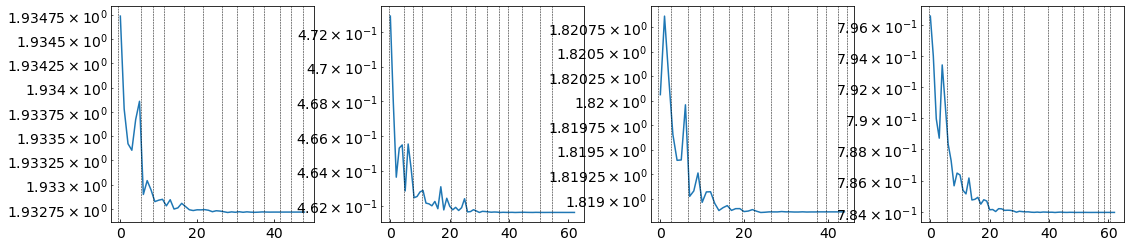

In [12]:
#
#  Plot learning curves
#

fig = plt.figure(figsize=(15, 3))
for obs_idx in range(num_observables) :
    model          = global_density_model.likelihood_models[obs_idx].model
    lr_record      = model.lr_record
    monitor_record = model.monitor_record
    ax = fig.add_axes([obs_idx/num_observables, 0., 0.75/num_observables, 1.])
    ax.plot(monitor_record)
    print(np.min(monitor_record))
    for val, lr in lr_record : ax.axvline(val-0.5, ls="--", lw=0.5, c="k")
    ax.set_yscale("log")
    ax.tick_params(which="both", direction="in", labelsize=14)
    
plt.show()


In [34]:
#
#  Save
#

global_density_model.save_to_dir(".Inference_test_model_v2")


In [14]:
#
#  Generate
#

n_sample = n_gen

print(f"Generating {n_sample} fake datapoints for [c0, c1] = [0, 0]")
start = time.time()
fake_white_datapoints_zero = global_density_model.sample(n_sample, [0, 0])
end = time.time()
print(f"{n_gen} datapoints generated at (0, 0) in {int(end-start):.0f}s")

fake_white_datapoints = {}
for c in c_gen :
    start = time.time()
    fake_white_datapoints[c] = global_density_model.sample(n_sample, c)
    end = time.time()
    print(f"{n_sample} datapoints generated at {c} in {(end-start):.2f}s")


Generating 50000 fake datapoints for [c0, c1] = [0, 0]
INFO       DensityModel.sample         Sampling 50000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 50000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 50000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 50000 datapoints, observable index is 3
50000 datapoints generated at (0, 0) in 34s
INFO       DensityModel.sample         Sampling 50000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 50000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 50000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 50000 datapoints, observable index is 3
50000 datapoints generated at (-1.5, -1.5) in 29.83s
INFO       DensityModel.sample         Sampling 50000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 50000 da

INFO       DensityModel.sample         Sampling 50000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 50000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 50000 datapoints, observable index is 3
50000 datapoints generated at (-0.5, 1.0) in 29.70s
INFO       DensityModel.sample         Sampling 50000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 50000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 50000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 50000 datapoints, observable index is 3
50000 datapoints generated at (-0.5, 1.5) in 29.62s
INFO       DensityModel.sample         Sampling 50000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 50000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 50000 datapoints, observable index is 2
INFO       Densi

INFO       DensityModel.sample         Sampling 50000 datapoints, observable index is 3
50000 datapoints generated at (1.0, 0.5) in 32.97s
INFO       DensityModel.sample         Sampling 50000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 50000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 50000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 50000 datapoints, observable index is 3
50000 datapoints generated at (1.0, 1.0) in 32.78s
INFO       DensityModel.sample         Sampling 50000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 50000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 50000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 50000 datapoints, observable index is 3
50000 datapoints generated at (1.0, 1.5) in 31.86s
INFO       DensityModel.sample         Sampling 50000 d

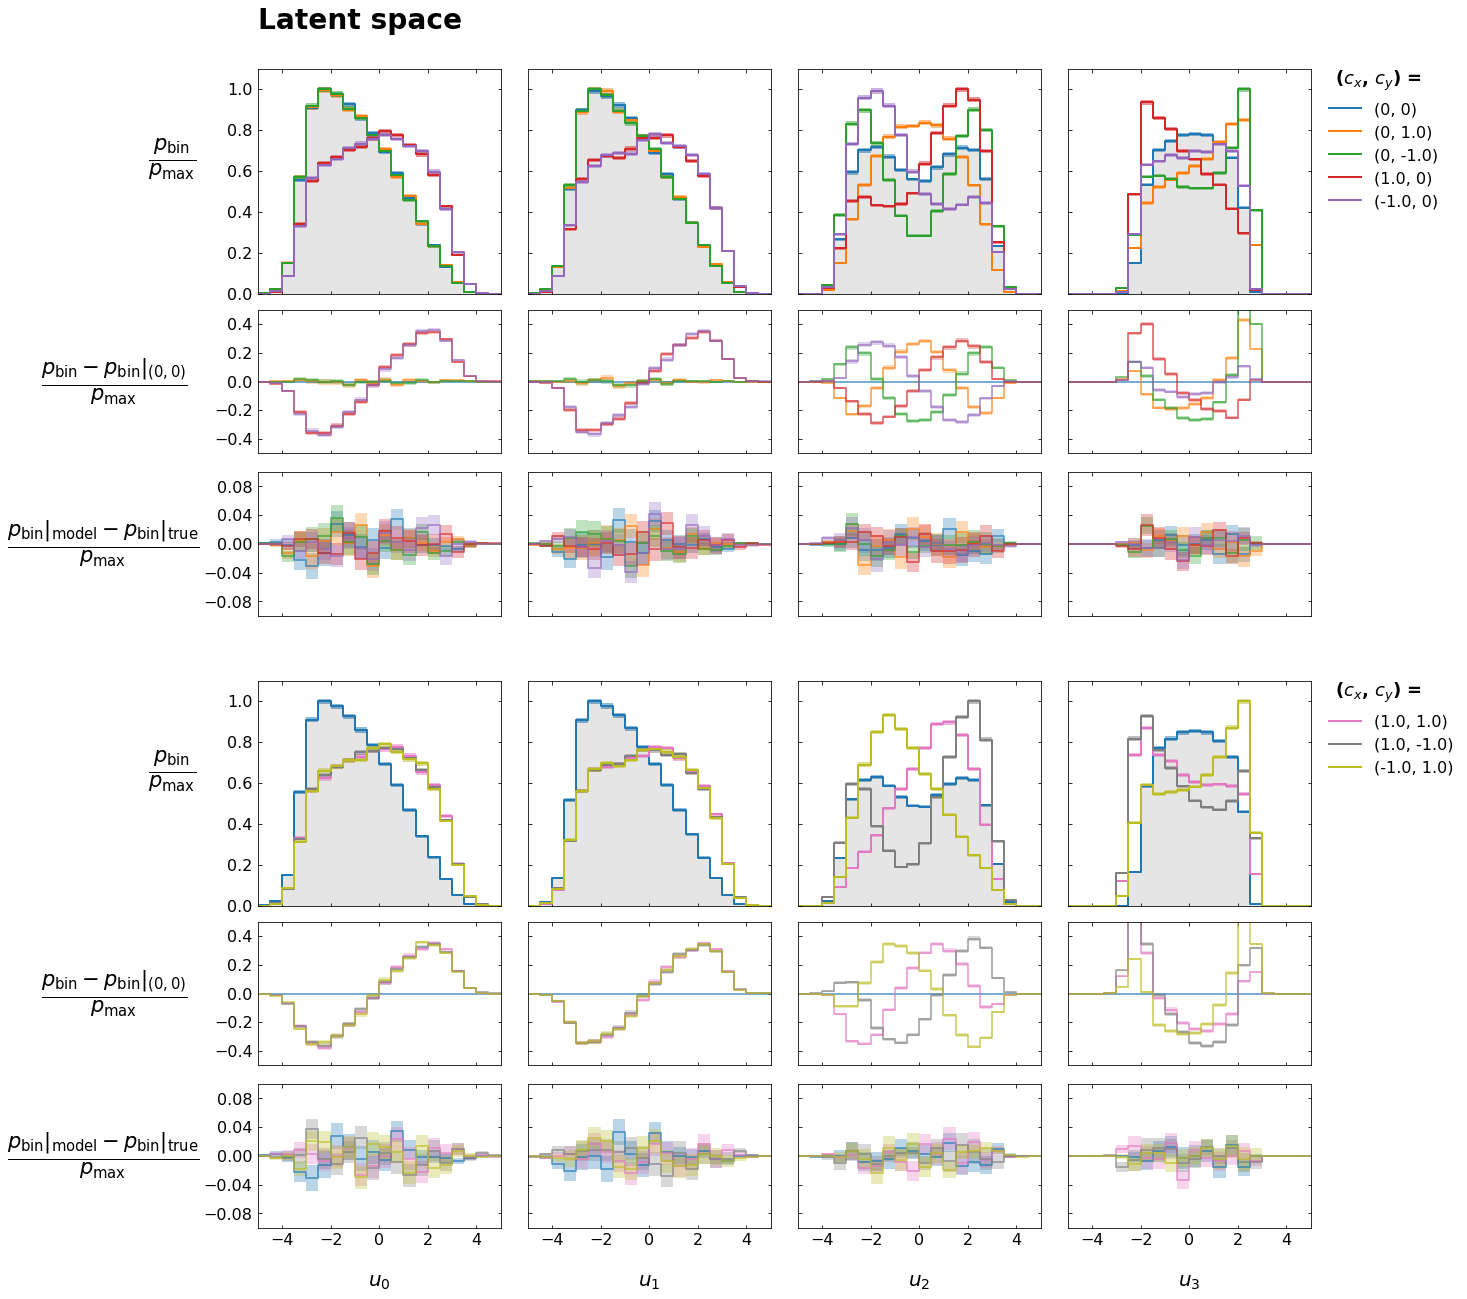

In [15]:
#  Plot 1D

prop_cycle = plt.rcParams['axes.prop_cycle']
colours = prop_cycle.by_key()['color']

def plot_with_fakes (c_plot, title="", savefig="") :
    fig = plt.figure(figsize=(15, 17))
    for row_idx in range(2) :
        c_offset = 5 if row_idx == 1 else 0
        axes = []
        for obs_idx in range(num_observables) :
            ax_top    = fig.add_axes([obs_idx/num_observables, (1-row_idx)*.5 + .45*(1-.59*.67/.95), 0.9/num_observables, .45*.58*.67/.95])
            obs_range = [-5, 5]
            hbins     = np.linspace(obs_range[0], obs_range[1], 21)
            ax_top.set_xlim([obs_range[0], obs_range[1]])
            ax_top.tick_params(axis="both", direction="in", right=True, top=True, labelsize=16, pad=5)
            ax_top.set_xticklabels([])
            if obs_idx > 0 : ax_top.set_yticklabels([])
            ypadmax, vals, vals_fake = 0., {}, {}
            for c_idx, c in enumerate(c_plot[row_idx]) :
                ds      = white_data[c][:,obs_idx]
                ds_fake = fake_white_datapoints[c][:,obs_idx]
                vals[c], _      = np.histogram(ds     , bins=hbins)
                vals_fake[c], _ = np.histogram(ds_fake, bins=hbins)
                ypadmax    = np.max([ypadmax, np.max(vals[c])])
            for c_idx, c in enumerate(c_plot[row_idx]) :
                colour = colours[c_offset+c_idx] if c_idx > 0 else colours[0]
                x, y, ey = histo_to_line(hbins, vals[c], np.sqrt(vals[c]))
                y, ey = y/ypadmax, ey/ypadmax
                ax_top.plot        (x, y, lw=2, label=None if row_idx>0 and c[0]==0 and c[1]==0 else f"{c}", c=colour)
                ax_top.fill_between(x, y-ey, y+ey, alpha=0.5, fc=colour)
                if (c[0] == 0) and (c[1] == 0) : ax_top.fill_between(x, 0*y, y, alpha=0.1, fc="black")
            ax_top.set_ylim(0, 1.1)

            ax_ratio = fig.add_axes([obs_idx/num_observables, (1-row_idx)*.5 + .45*(1.-.67/.95), 0.9/num_observables, .45*.37*.67/.95])
            ax_ratio.set_xlim([obs_range[0], obs_range[1]])
            ax_ratio.tick_params(axis="both", direction="in", right=True, top=True, labelsize=16, pad=5)
            if obs_idx > 0 : ax_ratio.set_yticklabels([])
            ax_ratio.set_ylim(-0.5, 0.5)
            ax_ratio.set_yticks([-0.4, -0.2, 0., 0.2, 0.4])
            ax_ratio.set_xticklabels([])

            for c_idx, c in enumerate(c_plot[row_idx]) :
                colour = colours[c_offset+c_idx] if c_idx > 0 else colours[0]
                x, y, ey       = histo_to_line(hbins, vals[c], np.sqrt(vals[c]))
                _, y_SM, ey_SM = histo_to_line(hbins, vals[(0,0)], np.sqrt(vals[(0,0)]))
                y, ey, y_SM, ey_SM = y/ypadmax, ey/ypadmax, y_SM/ypadmax, ey_SM/ypadmax
                ey_comb = np.sqrt(ey*ey + ey_SM*ey_SM)
                if (c[0] == 0) and (c[1] == 0) : ey_comb = 0.*ey_comb
                ax_ratio.plot        (x, y - y_SM, lw=2, c=colour, alpha=0.6)
                ax_ratio.fill_between(x, y - y_SM - ey_comb, y - y_SM + ey_comb, alpha=0.3, fc=colour)

            ax_ratio2 = fig.add_axes([obs_idx/num_observables, (1-row_idx)*.5, 0.9/num_observables, .45*.37*.67/.95])
            ax_ratio2.set_xlim([obs_range[0], obs_range[1]])
            ax_ratio2.tick_params(axis="both", direction="in", right=True, top=True, labelsize=16, pad=5)
            if obs_idx > 0 : ax_ratio2.set_yticklabels([])
            ax_ratio2.set_ylim(-0.1, 0.1)
            ax_ratio2.set_yticks([-0.08, -.04, 0., 0.04, 0.08])
            if row_idx == 0 :
                ax_ratio2.set_xticklabels([])
            else :
                ax_ratio2.set_xlabel(f"$u_{obs_idx}$", fontsize=20, labelpad=25, ha="center")

            for c_idx, c in enumerate(c_plot[row_idx]) :
                colour = colours[c_offset+c_idx] if c_idx > 0 else colours[0]
                x, y, ey     = histo_to_line(hbins, vals     [c], np.sqrt(vals     [c]))
                _, y_f, ey_f = histo_to_line(hbins, vals_fake[c], np.sqrt(vals_fake[c]))
                y, ey, y_f, ey_f = y/ypadmax, ey/ypadmax, y_f/ypadmax, ey_f/ypadmax
                ey_comb = np.sqrt(ey*ey + ey_f*ey_f)
                ax_ratio2.plot        (x, y - y_f, lw=2, c=colour, alpha=0.6)
                ax_ratio2.fill_between(x, y - y_f - ey_comb, y - y_f + ey_comb, alpha=0.3, fc=colour)

            axes.append([ax_top, ax_ratio, ax_ratio2])

        axes[-1][0].text(1.1, 1, r"($c_x$, $c_y$) =", ha="left", va="top", fontsize=18, weight="bold", transform=axes[-1][0].transAxes)
        axes[-1][0].legend(loc=(1.05, .35 if row_idx == 0 else .55), frameon=False, fontsize=16)
        axes[0 ][0].set_ylabel(r"$\frac{p_{\rm bin}}{p_{\rm max}}$", fontsize=30, rotation=0, labelpad=55)
        axes[0 ][1].set_ylabel(r"$\frac{p_{\rm bin} - p_{\rm bin}|_{(0,0)}}{p_{\rm max}}$", fontsize=30, rotation=0, labelpad=100, va="center")
        axes[0 ][2].set_ylabel(r"$\frac{p_{\rm bin}|_{\rm model} - p_{\rm bin}|_{\rm true}}{p_{\rm max}}$", fontsize=30, rotation=0, labelpad=100, va="center")
        if (len(title) > 0) and (row_idx == 0) : axes[0][0].text(0, 1.15, title, ha="left", va="bottom", fontsize=28, weight="bold", transform=axes[0][0].transAxes)

    if len(savefig) > 0 : plt.savefig(savefig, bbox_inches="tight")
    plt.show()

plot_with_fakes([[(0, 0), (0, 1.), (0, -1.), (1., 0), (-1., 0)], [(0, 0), (1., 1.), (1., -1.), (-1., 1.)]],
                title="Latent space", savefig="figures/paper2D_toy_model/latent_distributions.pdf")


Performing analytic fit for c = [-0.8, -0.8]  (attempt 1)
[-0.81168589 -0.81688268] 0.3 0.2
Plotting c = [-0.8, -0.8]
Performing model fit for c = [-0.8, -0.8]  (attempt 1)
[-0.79819154 -0.82257686] 0.3 0.2
Plotting c = [-0.8, -0.8]


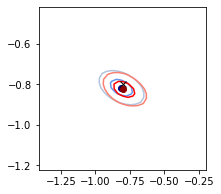

Performing analytic fit for c = [-0.8, 0.0]  (attempt 1)
[-7.06205602e-01 -4.39263037e-06] 0.3 0.2
Plotting c = [-0.8, 0.0]
Performing model fit for c = [-0.8, 0.0]  (attempt 1)
[-0.71785937  0.00154575] 0.3 0.2
Plotting c = [-0.8, 0.0]


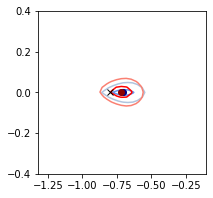

Performing analytic fit for c = [-0.8, 0.8]  (attempt 1)
[-0.85241944  0.80093159] 0.3 0.2
Plotting c = [-0.8, 0.8]
Performing model fit for c = [-0.8, 0.8]  (attempt 1)
[-0.83810576  0.80899037] 0.3 0.2
Plotting c = [-0.8, 0.8]


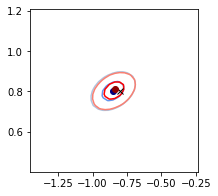

Performing analytic fit for c = [0.0, -0.8]  (attempt 1)
[ 0.10749363 -0.71963114] 0.3 0.2
Plotting c = [0.0, -0.8]
Performing model fit for c = [0.0, -0.8]  (attempt 1)
[ 0.19589365 -0.69788524] 0.3 0.2
Plotting c = [0.0, -0.8]


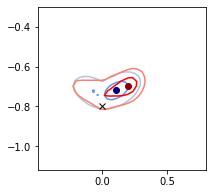

Performing analytic fit for c = [0.0, 0.0]  (attempt 1)
[0. 0.] 0.3 0.2
Plotting c = [0.0, 0.0]
Performing model fit for c = [0.0, 0.0]  (attempt 1)
[0.00648927 0.00303821] 0.3 0.2
Plotting c = [0.0, 0.0]


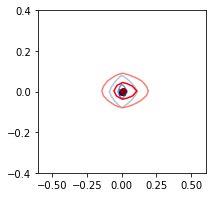

Performing analytic fit for c = [0.0, 0.8]  (attempt 1)
[0.01564603 0.78638427] 0.3 0.2
Plotting c = [0.0, 0.8]
Performing model fit for c = [0.0, 0.8]  (attempt 1)
[2.69328857e-04 7.91399524e-01] 0.3 0.2
Plotting c = [0.0, 0.8]


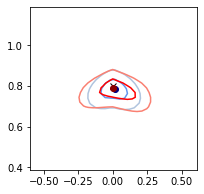

Performing analytic fit for c = [0.8, -0.8]  (attempt 1)
[ 0.65488148 -0.83880356] 0.3 0.2
Plotting c = [0.8, -0.8]
Performing model fit for c = [0.8, -0.8]  (attempt 1)
[ 0.65194711 -0.84790602] 0.3 0.2
Plotting c = [0.8, -0.8]


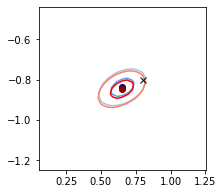

Performing analytic fit for c = [0.8, 0.0]  (attempt 1)
[0.73505855 0.00492459] 0.3 0.2
Plotting c = [0.8, 0.0]
Performing model fit for c = [0.8, 0.0]  (attempt 1)
[0.73026443 0.05774193] 0.3 0.2
Plotting c = [0.8, 0.0]


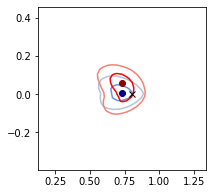

Performing analytic fit for c = [0.8, 0.8]  (attempt 1)
[0.85361196 0.7777715 ] 0.3 0.2
Plotting c = [0.8, 0.8]
Performing model fit for c = [0.8, 0.8]  (attempt 1)
[0.85261475 0.77929396] 0.3 0.2
Plotting c = [0.8, 0.8]


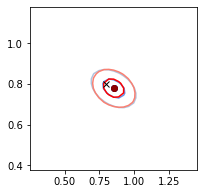

In [29]:

c0_test, c1_test = np.linspace(-0.8, 0.8, 3), np.linspace(-0.8, 0.8, 3)
    
plot_data = {}
for c0 in c0_test :
    for c1 in c1_test :
        
        fig = plt.figure(figsize=(3, 3))
        ax  = fig.add_subplot(1, 1, 1)
                    
        c = [c0, c1]
        ds          = generate(c, n_true)
        white_ds, _ = whiten_axes(ds, [float for i in range(num_observables)], axis_configs=axis_configs, whitening_funcs=whitening_funcs)
        weights     = np.ones(shape=(len(white_ds),1))
        
        func1 = lambda cp : -2. * evaluate(cp, ds)
        #func1 = lambda cp : -2. * evaluate_partial(cp, ds)
        is_valid, counter = False, 0
        while (not is_valid) and (counter < 5) :
            print(f"Performing analytic fit for c = {c}  (attempt {counter+1})")
            m1    = Minuit.from_array_func(func1, 
                                           c, 
                                           name = ["c0", "c1"],
                                           error = [0.5, 0.5], 
                                           errordef = 8)
            m1.migrad()
            is_valid = m1.get_fmin().is_valid
            counter += 1
        if not m1.get_fmin().is_valid :
            print(f"WARNING: {c} did not converge (m1)")
            continue
        #m1.minos()
        TNLL_min1 = m1.fval
        c_min1    = m1.np_values()
        c_err1    = np.array([0.3, 0.2]) # np.min(m1.np_merrors()[0]), np.max(m1.np_merrors()[1])
        print(c_min1, c_err1[0], c_err1[1])
        
        print(f"Plotting c = {c}")
        num_pts_x, num_pts_y = 35, 35
        X1, Y1 = np.linspace(c_min1[0]-2.*c_err1[0], c_min1[0]+2.*c_err1[0], num_pts_x), np.linspace(c_min1[1]-2.*c_err1[1], c_min1[1]+2.*c_err1[1], num_pts_y)
        X1, Y1 = np.meshgrid(X1, Y1, indexing='xy')
        Z1     = np.zeros_like(X1)
        for j in range(num_pts_y) :
            for i in range(num_pts_x) :
                Z1[j, i] = func1([X1[j, i], Y1[j, i]]) - TNLL_min1
        ax.contour(X1, Y1, Z1, levels=[1, 4], colors=["cornflowerblue", "lightsteelblue"])
        ax.plot(c_min1[0], c_min1[1], "o", c="navy" )
        ax.plot(c     [0], c     [1], "x", c="black")
            
        func2 = lambda cp : -2. * np.sum(np.log(global_density_model.evaluate(cp, white_ds)))
        #func2 = lambda cp : -2. * np.sum(global_density_model.evaluate_over_dataset({tuple(cp):white_ds}, {tuple(cp):weights})[-1])
        is_valid, counter = False, 0
        while (not is_valid) and (counter < 5) :
            print(f"Performing model fit for c = {c}  (attempt {counter+1})")
            m2    = Minuit.from_array_func(func2, 
                                           c, 
                                           name = ["c0", "c1"],
                                           error = [0.5, 0.5], 
                                           errordef = 6)
            m2.migrad()
            is_valid = m2.get_fmin().is_valid
            counter += 1
        if not m2.get_fmin().is_valid :
            print(f"WARNING: {c} did not converge (m2)")
            continue
        #m2.minos()
        TNLL_min2 = m2.fval
        c_min2    = m2.np_values()
        c_err2    = np.array([0.3, 0.2]) # np.min(m2.np_merrors()[0]), np.max(m2.np_merrors()[1])
        print(c_min2, c_err2[0], c_err2[1])

        print(f"Plotting c = {c}")
        X2, Y2 = np.linspace(c_min2[0]-2.*c_err2[0], c_min2[0]+2.*c_err2[0], num_pts_x), np.linspace(c_min2[1]-2.*c_err2[1], c_min2[1]+2.*c_err2[1], num_pts_y)
        X2, Y2 = np.meshgrid(X2, Y2, indexing='xy')
        Z2 = np.zeros_like(X2)
        for j in range(num_pts_y) :
            for i in range(num_pts_x) :
                Z2[j, i] = func2([X2[j, i], Y2[j, i]]) - TNLL_min2
        ax.contour(X2, Y2, Z2, levels=[1, 4], colors=["red", "salmon"])
        ax.plot(c_min2[0], c_min2[1], "o", c="darkred" )
        
        plot_data[tuple(c)] = [ds, c_min1, c_err1, X1, Y1, Z1, c_min2, c_err2, X2, Y2, Z2]

        plt.show()


q_68 is 0.989
q_95 is 3.841


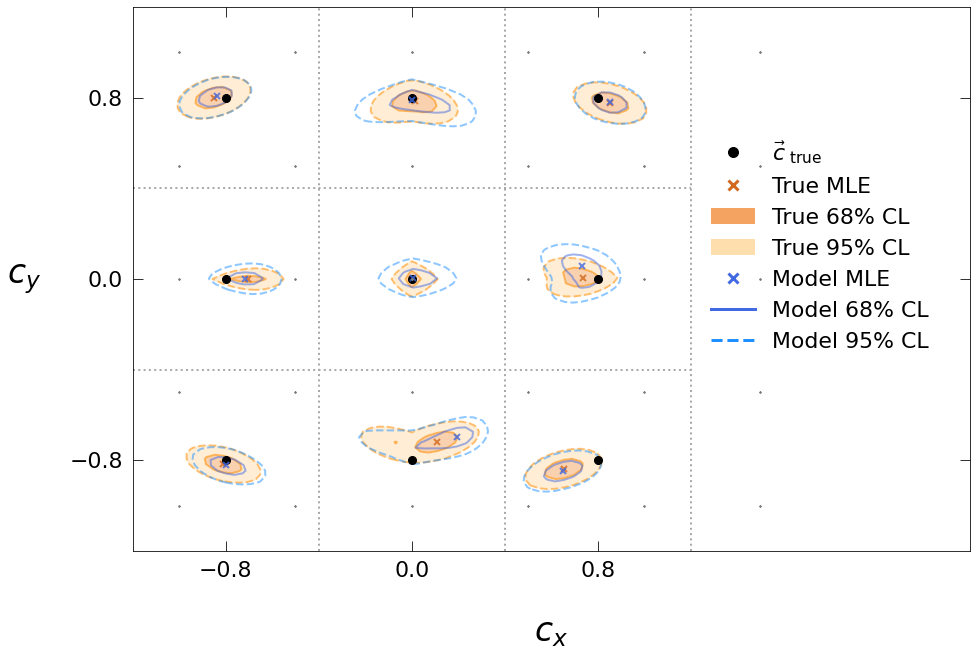

In [33]:
from matplotlib import lines

q_68, q_95 = np.interp([.68, .95], stats.chi2.cdf(np.linspace(0, 5, 501), 1), np.linspace(0, 5, 501))
print(f"q_68 is {q_68:.3f}")
print(f"q_95 is {q_95:.3f}")

fig = plt.figure(figsize=(15, 10))
ax  = fig.add_subplot(1, 1, 1)
        
for c, [ds, c_min1, c_err1, X1, Y1, Z1, c_min2, c_err2, X2, Y2, Z2], in plot_data.items() :
    ax.contour (X1, Y1, Z1, levels=[q_68, q_95]   , colors=["darkorange", "darkorange"], linewidths=2, linestyles=["-", "--"], alpha=0.5)
    ax.contourf(X1, Y1, Z1, levels=[0, q_68, q_95], colors=["sandybrown", "navajowhite"], alpha=0.5)
    ax.plot(c_min1[0], c_min1[1], "x", c="chocolate", ms=6, mew=2, alpha=0.8)
    ax.plot(c     [0], c     [1], "o", c="black", ms=8)
    ax.contour(X2, Y2, Z2, levels=[1, 4], colors=["royalblue", "dodgerblue"], linewidths=2, linestyles=["-", "--"], alpha=0.5)
    ax.plot(c_min2[0], c_min2[1], "x", c="royalblue", ms=6, mew=2, alpha=0.8)
    
for c0 in c0_gen :
    for c1 in c1_gen :
        ax.plot(c0, c1, "*", c="grey", ms=2)
    
ax.set_xlim([-1.2, 2.4])
ax.set_ylim([-1.2, 1.2])
ax.plot([-1.2, 1.2], [-0.4, -0.4], lw=2, ls=":", c="darkgrey")
ax.plot([-1.2, 1.2], [ 0.4,  0.4], lw=2, ls=":", c="darkgrey")
ax.plot([-0.4, -0.4], [-1.2, 1.2], lw=2, ls=":", c="darkgrey")
ax.plot([ 0.4,  0.4], [-1.2, 1.2], lw=2, ls=":", c="darkgrey")
ax.plot([ 1.2,  1.2], [-1.2, 1.2], lw=2, ls=":", c="darkgrey")
ax.plot(-0.4, lw=2, ls="--", c="grey")
ax.plot( 0.4, lw=2, ls="--", c="grey")
ax.set_xticks([-.8, 0., .8])
ax.set_yticks([-.8, 0., .8])
ax.tick_params(axis="both", direction="in", right=True, top=True, length=10, labelsize=22, pad=10)
ax.set_xlabel("$c_x$", fontsize=33, labelpad=35)
ax.set_ylabel("$c_y$", fontsize=33, labelpad=45, rotation=0, va="center")
    
proxy = [lines.Line2D([], [], color='black'    , marker='o', linestyle='None', markersize=10), 
         lines.Line2D([], [], color='chocolate', marker='x', linestyle='None', markersize=10, mew=3), 
         plt.Rectangle((0,0),1,1,fc="sandybrown"), 
         plt.Rectangle((0,0),1,1,fc="navajowhite"),
         lines.Line2D([], [], color='royalblue' , marker='x', linestyle='None', markersize=10, mew=3), 
         lines.Line2D([], [], color='royalblue' , linestyle='-' , lw=3), 
         lines.Line2D([], [], color='dodgerblue', linestyle='--', lw=3)]
ax.legend(proxy,
          [r"${\vec c}_{\rm ~true}$",
           "True MLE", "True 68% CL", "True 95% CL",
           "Model MLE", "Model 68% CL", "Model 95% CL"],
              loc=(0.68, 0.35), frameon=False, fontsize=22, labelspacing=.5)
    
plt.savefig(f"figures/paper2D_toy_model/contours.pdf", bbox_inches="tight")
plt.show()
